# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
# loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array(1)), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 990.349748
Epoch 1, loss: 960.474339
Epoch 2, loss: 1117.895552
Epoch 3, loss: 805.534902
Epoch 4, loss: 998.654468
Epoch 5, loss: 984.046805
Epoch 6, loss: 967.838460
Epoch 7, loss: 994.983572
Epoch 8, loss: 965.671002
Epoch 9, loss: 940.915788


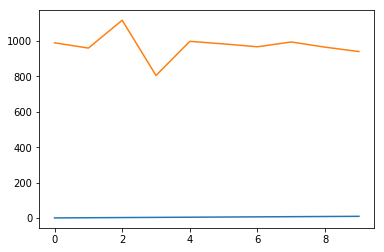

In [12]:
# let's look at the loss history!
plt.plot(loss_history)

In [15]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.106
Epoch 0, loss: 709.417762
Epoch 1, loss: 878.676700
Epoch 2, loss: 1004.697085
Epoch 3, loss: 806.923815
Epoch 4, loss: 949.274924
Epoch 5, loss: 882.866423
Epoch 6, loss: 916.066056
Epoch 7, loss: 867.505560
Epoch 8, loss: 766.241315
Epoch 9, loss: 899.954628
Epoch 10, loss: 811.052468
Epoch 11, loss: 899.645544
Epoch 12, loss: 828.417845
Epoch 13, loss: 858.530005
Epoch 14, loss: 906.416982
Epoch 15, loss: 885.264229
Epoch 16, loss: 908.914871
Epoch 17, loss: 942.836598
Epoch 18, loss: 783.323236
Epoch 19, loss: 952.931391
Epoch 20, loss: 836.209969
Epoch 21, loss: 1055.254539
Epoch 22, loss: 942.074216
Epoch 23, loss: 830.195819
Epoch 24, loss: 900.679657
Epoch 25, loss: 866.889627
Epoch 26, loss: 913.177136
Epoch 27, loss: 930.862835
Epoch 28, loss: 776.196752
Epoch 29, loss: 963.191424
Epoch 30, loss: 1053.557470
Epoch 31, loss: 970.104826
Epoch 32, loss: 779.622029
Epoch 33, loss: 992.935093
Epoch 34, loss: 1149.791136
Epoch 35, loss: 920.385895
Epoch 36, loss: 1

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [17]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1e-4, 1e-5, 1e-6, 1e-7]

results = []
for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)

        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)

        results.append((accuracy, lr, rs))

results.sort(key=lambda x: x[0], reverse = True)

for result in results:
    print("Accuracy: %f, learning rate: %f, reg strength: %f" % result)

Epoch 0, loss: 971.966726
Epoch 1, loss: 881.255680
Epoch 2, loss: 822.309094
Epoch 3, loss: 946.137392
Epoch 4, loss: 1091.136520
Epoch 5, loss: 874.283318
Epoch 6, loss: 876.654545
Epoch 7, loss: 992.741840
Epoch 8, loss: 982.746273
Epoch 9, loss: 800.137422
Epoch 10, loss: 901.733074
Epoch 11, loss: 838.125784
Epoch 12, loss: 792.430506
Epoch 13, loss: 1009.397009
Epoch 14, loss: 885.335008
Epoch 15, loss: 770.245175
Epoch 16, loss: 914.646438
Epoch 17, loss: 879.523202
Epoch 18, loss: 1048.021301
Epoch 19, loss: 1029.878980
Epoch 20, loss: 861.151600
Epoch 21, loss: 933.703469
Epoch 22, loss: 1053.195049
Epoch 23, loss: 888.946948
Epoch 24, loss: 808.314295
Epoch 25, loss: 739.817964
Epoch 26, loss: 910.591022
Epoch 27, loss: 824.284249
Epoch 28, loss: 1032.727598
Epoch 29, loss: 910.926780
Epoch 30, loss: 884.842614
Epoch 31, loss: 819.832188
Epoch 32, loss: 891.657752
Epoch 33, loss: 766.917349
Epoch 34, loss: 1068.757265
Epoch 35, loss: 943.204402
Epoch 36, loss: 894.911403
Epoc

Epoch 99, loss: 850.616116
Epoch 100, loss: 870.668828
Epoch 101, loss: 768.046673
Epoch 102, loss: 860.168071
Epoch 103, loss: 876.655479
Epoch 104, loss: 768.643849
Epoch 105, loss: 858.650152
Epoch 106, loss: 908.248201
Epoch 107, loss: 997.588054
Epoch 108, loss: 805.176095
Epoch 109, loss: 836.560770
Epoch 110, loss: 1005.908933
Epoch 111, loss: 979.182544
Epoch 112, loss: 953.674011
Epoch 113, loss: 839.023752
Epoch 114, loss: 921.955608
Epoch 115, loss: 814.670450
Epoch 116, loss: 962.633922
Epoch 117, loss: 1015.559953
Epoch 118, loss: 981.513567
Epoch 119, loss: 883.449967
Epoch 120, loss: 761.715468
Epoch 121, loss: 756.511594
Epoch 122, loss: 825.670032
Epoch 123, loss: 858.475683
Epoch 124, loss: 854.976692
Epoch 125, loss: 1035.315256
Epoch 126, loss: 858.425668
Epoch 127, loss: 942.742725
Epoch 128, loss: 1058.525387
Epoch 129, loss: 862.755773
Epoch 130, loss: 872.307785
Epoch 131, loss: 724.503939
Epoch 132, loss: 960.969453
Epoch 133, loss: 874.174841
Epoch 134, loss: 

Epoch 195, loss: 1030.658116
Epoch 196, loss: 839.001950
Epoch 197, loss: 906.806280
Epoch 198, loss: 892.044601
Epoch 199, loss: 858.724470
Epoch 0, loss: 1046.565095
Epoch 1, loss: 920.413155
Epoch 2, loss: 783.353562
Epoch 3, loss: 955.481161
Epoch 4, loss: 856.046264
Epoch 5, loss: 985.470827
Epoch 6, loss: 784.512456
Epoch 7, loss: 1081.306306
Epoch 8, loss: 956.045397
Epoch 9, loss: 810.204367
Epoch 10, loss: 751.365222
Epoch 11, loss: 892.621310
Epoch 12, loss: 959.119022
Epoch 13, loss: 1077.567037
Epoch 14, loss: 808.156909
Epoch 15, loss: 728.647742
Epoch 16, loss: 765.846498
Epoch 17, loss: 969.748976
Epoch 18, loss: 1075.386027
Epoch 19, loss: 920.463079
Epoch 20, loss: 828.026406
Epoch 21, loss: 830.099091
Epoch 22, loss: 797.933955
Epoch 23, loss: 865.412851
Epoch 24, loss: 902.464253
Epoch 25, loss: 924.158861
Epoch 26, loss: 795.102467
Epoch 27, loss: 845.190855
Epoch 28, loss: 896.466257
Epoch 29, loss: 1092.354232
Epoch 30, loss: 990.025093
Epoch 31, loss: 1090.690982

Epoch 95, loss: 672.741905
Epoch 96, loss: 674.031431
Epoch 97, loss: 674.690989
Epoch 98, loss: 672.897216
Epoch 99, loss: 672.673522
Epoch 100, loss: 675.247094
Epoch 101, loss: 674.852668
Epoch 102, loss: 674.299692
Epoch 103, loss: 672.826055
Epoch 104, loss: 672.610411
Epoch 105, loss: 675.184021
Epoch 106, loss: 672.736835
Epoch 107, loss: 673.683614
Epoch 108, loss: 673.856104
Epoch 109, loss: 672.758352
Epoch 110, loss: 671.649074
Epoch 111, loss: 673.898908
Epoch 112, loss: 675.475448
Epoch 113, loss: 671.940967
Epoch 114, loss: 674.081047
Epoch 115, loss: 673.283446
Epoch 116, loss: 677.836453
Epoch 117, loss: 672.785229
Epoch 118, loss: 672.255367
Epoch 119, loss: 672.451088
Epoch 120, loss: 672.699441
Epoch 121, loss: 672.703701
Epoch 122, loss: 673.737771
Epoch 123, loss: 673.873616
Epoch 124, loss: 672.332440
Epoch 125, loss: 673.217938
Epoch 126, loss: 672.179267
Epoch 127, loss: 674.242139
Epoch 128, loss: 672.214266
Epoch 129, loss: 673.879029
Epoch 130, loss: 674.7436

Epoch 192, loss: 672.818646
Epoch 193, loss: 674.354483
Epoch 194, loss: 673.407279
Epoch 195, loss: 674.664027
Epoch 196, loss: 673.111402
Epoch 197, loss: 674.239368
Epoch 198, loss: 673.674985
Epoch 199, loss: 672.744234
Epoch 0, loss: 687.830237
Epoch 1, loss: 684.900087
Epoch 2, loss: 685.652976
Epoch 3, loss: 682.064890
Epoch 4, loss: 680.371168
Epoch 5, loss: 681.471428
Epoch 6, loss: 678.582502
Epoch 7, loss: 678.192235
Epoch 8, loss: 677.775457
Epoch 9, loss: 675.236529
Epoch 10, loss: 676.404504
Epoch 11, loss: 675.256499
Epoch 12, loss: 676.222170
Epoch 13, loss: 673.702250
Epoch 14, loss: 675.931497
Epoch 15, loss: 673.852425
Epoch 16, loss: 674.490837
Epoch 17, loss: 674.459778
Epoch 18, loss: 674.377570
Epoch 19, loss: 672.447721
Epoch 20, loss: 673.613011
Epoch 21, loss: 673.459896
Epoch 22, loss: 673.573117
Epoch 23, loss: 675.618525
Epoch 24, loss: 674.714882
Epoch 25, loss: 672.937410
Epoch 26, loss: 674.611129
Epoch 27, loss: 673.501006
Epoch 28, loss: 673.539858
Epo

Epoch 93, loss: 673.990621
Epoch 94, loss: 670.940928
Epoch 95, loss: 674.176676
Epoch 96, loss: 673.058717
Epoch 97, loss: 672.132565
Epoch 98, loss: 671.840864
Epoch 99, loss: 674.390544
Epoch 100, loss: 672.109520
Epoch 101, loss: 673.887469
Epoch 102, loss: 672.746897
Epoch 103, loss: 674.107027
Epoch 104, loss: 674.446046
Epoch 105, loss: 672.663813
Epoch 106, loss: 674.884128
Epoch 107, loss: 671.404141
Epoch 108, loss: 673.236046
Epoch 109, loss: 674.757390
Epoch 110, loss: 674.923655
Epoch 111, loss: 673.702252
Epoch 112, loss: 674.757293
Epoch 113, loss: 672.992491
Epoch 114, loss: 675.072537
Epoch 115, loss: 672.930148
Epoch 116, loss: 673.098600
Epoch 117, loss: 673.322190
Epoch 118, loss: 672.068656
Epoch 119, loss: 675.647881
Epoch 120, loss: 671.574007
Epoch 121, loss: 673.263885
Epoch 122, loss: 670.721448
Epoch 123, loss: 671.874772
Epoch 124, loss: 673.477892
Epoch 125, loss: 672.214841
Epoch 126, loss: 673.287146
Epoch 127, loss: 674.412848
Epoch 128, loss: 674.288577

Epoch 190, loss: 673.184881
Epoch 191, loss: 672.967273
Epoch 192, loss: 672.802317
Epoch 193, loss: 673.662136
Epoch 194, loss: 673.256887
Epoch 195, loss: 673.389605
Epoch 196, loss: 673.917125
Epoch 197, loss: 673.092732
Epoch 198, loss: 673.806752
Epoch 199, loss: 672.951260
Epoch 0, loss: 691.626928
Epoch 1, loss: 690.433623
Epoch 2, loss: 689.768886
Epoch 3, loss: 689.545007
Epoch 4, loss: 689.653146
Epoch 5, loss: 688.987700
Epoch 6, loss: 688.408183
Epoch 7, loss: 688.143171
Epoch 8, loss: 688.508994
Epoch 9, loss: 687.822513
Epoch 10, loss: 687.904963
Epoch 11, loss: 686.973174
Epoch 12, loss: 686.618894
Epoch 13, loss: 686.519575
Epoch 14, loss: 686.787765
Epoch 15, loss: 686.747103
Epoch 16, loss: 684.654948
Epoch 17, loss: 685.593237
Epoch 18, loss: 685.211354
Epoch 19, loss: 686.014717
Epoch 20, loss: 685.775280
Epoch 21, loss: 684.255874
Epoch 22, loss: 684.218456
Epoch 23, loss: 684.033079
Epoch 24, loss: 684.336922
Epoch 25, loss: 683.320036
Epoch 26, loss: 684.508838
E

Epoch 91, loss: 675.421766
Epoch 92, loss: 675.287935
Epoch 93, loss: 676.299523
Epoch 94, loss: 675.699554
Epoch 95, loss: 675.626147
Epoch 96, loss: 676.140836
Epoch 97, loss: 675.891339
Epoch 98, loss: 675.161584
Epoch 99, loss: 675.279091
Epoch 100, loss: 675.343301
Epoch 101, loss: 675.350036
Epoch 102, loss: 675.501690
Epoch 103, loss: 675.503107
Epoch 104, loss: 676.132642
Epoch 105, loss: 675.187423
Epoch 106, loss: 675.471879
Epoch 107, loss: 675.509322
Epoch 108, loss: 674.674406
Epoch 109, loss: 675.073277
Epoch 110, loss: 675.430784
Epoch 111, loss: 675.065581
Epoch 112, loss: 675.104132
Epoch 113, loss: 675.602954
Epoch 114, loss: 674.536256
Epoch 115, loss: 675.243830
Epoch 116, loss: 675.417446
Epoch 117, loss: 675.835909
Epoch 118, loss: 674.567912
Epoch 119, loss: 674.302235
Epoch 120, loss: 673.675745
Epoch 121, loss: 675.068184
Epoch 122, loss: 674.869660
Epoch 123, loss: 674.821136
Epoch 124, loss: 674.982369
Epoch 125, loss: 674.831759
Epoch 126, loss: 674.811680
E

Epoch 188, loss: 674.296845
Epoch 189, loss: 672.460345
Epoch 190, loss: 673.682891
Epoch 191, loss: 673.983340
Epoch 192, loss: 673.679935
Epoch 193, loss: 673.385000
Epoch 194, loss: 672.716758
Epoch 195, loss: 672.859053
Epoch 196, loss: 673.548833
Epoch 197, loss: 672.892149
Epoch 198, loss: 673.474875
Epoch 199, loss: 674.202413
Epoch 0, loss: 690.562183
Epoch 1, loss: 690.867336
Epoch 2, loss: 690.961444
Epoch 3, loss: 690.700064
Epoch 4, loss: 690.629748
Epoch 5, loss: 690.641490
Epoch 6, loss: 690.332787
Epoch 7, loss: 690.348032
Epoch 8, loss: 690.541502
Epoch 9, loss: 690.370002
Epoch 10, loss: 690.643058
Epoch 11, loss: 690.525330
Epoch 12, loss: 690.226112
Epoch 13, loss: 690.287151
Epoch 14, loss: 690.213435
Epoch 15, loss: 690.555121
Epoch 16, loss: 690.378945
Epoch 17, loss: 690.235605
Epoch 18, loss: 690.190355
Epoch 19, loss: 690.062318
Epoch 20, loss: 690.054474
Epoch 21, loss: 690.083653
Epoch 22, loss: 690.335365
Epoch 23, loss: 690.122632
Epoch 24, loss: 690.005060

Epoch 89, loss: 687.791646
Epoch 90, loss: 687.981863
Epoch 91, loss: 688.115831
Epoch 92, loss: 687.946748
Epoch 93, loss: 688.073289
Epoch 94, loss: 687.827820
Epoch 95, loss: 687.778228
Epoch 96, loss: 687.880254
Epoch 97, loss: 687.794532
Epoch 98, loss: 687.759846
Epoch 99, loss: 688.026240
Epoch 100, loss: 687.679728
Epoch 101, loss: 687.640107
Epoch 102, loss: 687.628487
Epoch 103, loss: 687.176478
Epoch 104, loss: 687.566045
Epoch 105, loss: 687.750398
Epoch 106, loss: 687.503826
Epoch 107, loss: 687.531753
Epoch 108, loss: 687.669370
Epoch 109, loss: 687.391928
Epoch 110, loss: 687.266888
Epoch 111, loss: 687.541021
Epoch 112, loss: 687.329761
Epoch 113, loss: 687.362444
Epoch 114, loss: 687.108035
Epoch 115, loss: 687.200553
Epoch 116, loss: 687.147891
Epoch 117, loss: 687.101211
Epoch 118, loss: 686.903816
Epoch 119, loss: 687.157196
Epoch 120, loss: 687.056708
Epoch 121, loss: 687.409905
Epoch 122, loss: 687.209514
Epoch 123, loss: 687.000156
Epoch 124, loss: 687.127660
Epo

Epoch 186, loss: 685.174517
Epoch 187, loss: 685.554282
Epoch 188, loss: 685.473579
Epoch 189, loss: 685.668541
Epoch 190, loss: 685.468775
Epoch 191, loss: 685.427287
Epoch 192, loss: 685.285435
Epoch 193, loss: 685.456942
Epoch 194, loss: 685.448886
Epoch 195, loss: 685.344979
Epoch 196, loss: 685.289958
Epoch 197, loss: 685.037578
Epoch 198, loss: 684.968302
Epoch 199, loss: 685.001083
Epoch 0, loss: 690.925657
Epoch 1, loss: 690.921694
Epoch 2, loss: 691.119248
Epoch 3, loss: 690.983626
Epoch 4, loss: 690.416158
Epoch 5, loss: 690.754309
Epoch 6, loss: 690.672454
Epoch 7, loss: 690.424888
Epoch 8, loss: 690.223714
Epoch 9, loss: 690.380569
Epoch 10, loss: 690.303091
Epoch 11, loss: 690.391843
Epoch 12, loss: 690.178858
Epoch 13, loss: 690.275523
Epoch 14, loss: 690.294909
Epoch 15, loss: 690.266398
Epoch 16, loss: 690.144406
Epoch 17, loss: 690.221980
Epoch 18, loss: 690.171738
Epoch 19, loss: 689.956243
Epoch 20, loss: 690.087854
Epoch 21, loss: 689.823868
Epoch 22, loss: 690.0122

# Какой же точности мы добились на тестовых данных?

In [24]:
classifier = linear_classifer.LinearSoftmaxClassifier()
classifier.fit(train_X, train_y, epochs=200, learning_rate=1e-5, batch_size=300, reg=1e-6)

test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Epoch 0, loss: 691.228552
Epoch 1, loss: 690.111231
Epoch 2, loss: 689.605051
Epoch 3, loss: 689.508944
Epoch 4, loss: 688.563788
Epoch 5, loss: 688.987323
Epoch 6, loss: 688.264936
Epoch 7, loss: 687.906390
Epoch 8, loss: 687.758693
Epoch 9, loss: 687.241499
Epoch 10, loss: 687.803391
Epoch 11, loss: 687.293523
Epoch 12, loss: 686.938214
Epoch 13, loss: 686.379923
Epoch 14, loss: 686.211990
Epoch 15, loss: 685.880932
Epoch 16, loss: 685.400938
Epoch 17, loss: 685.298200
Epoch 18, loss: 685.650973
Epoch 19, loss: 685.075083
Epoch 20, loss: 684.357766
Epoch 21, loss: 684.616243
Epoch 22, loss: 684.547610
Epoch 23, loss: 683.766468
Epoch 24, loss: 684.095723
Epoch 25, loss: 683.881756
Epoch 26, loss: 683.749429
Epoch 27, loss: 683.435497
Epoch 28, loss: 683.516467
Epoch 29, loss: 682.338695
Epoch 30, loss: 682.329847
Epoch 31, loss: 682.193330
Epoch 32, loss: 682.784157
Epoch 33, loss: 682.466266
Epoch 34, loss: 681.305935
Epoch 35, loss: 682.258331
Epoch 36, loss: 681.217934
Epoch 37, l